In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.feature_selection import RFECV, RFE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.width', 1000)  # Adjust width to prevent wrapping (tweak this number based on your display)

In [2]:
def feature_selection(base_model , X_train_full, y_train):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44449999)
    rfecv = RFECV(estimator=base_model, step=1, cv=cv, scoring='accuracy')
    rfecv.fit(X_train_full, y_train)
    gr = rfecv.cv_results_
    
    num_features = list(range(1, len(gr['mean_test_score']) + 1))
    mean_minus_std = np.array(gr['mean_test_score']) - np.array(gr['std_test_score'])
    
    idx = np.argmax(mean_minus_std)
    
    num_features_selected = num_features[idx]
    
    rfe = RFE(estimator=base_model, n_features_to_select=num_features_selected, step=1)
    rfe.fit(X_train_full, y_train)
    selected_cols = X_train_full.columns[(rfe.support_)]
    return selected_cols

In [3]:
dataset = pd.read_csv("fourth_down_dataset.csv")
print(dataset['play_type'].value_counts())
dataset = dataset.dropna(subset=['play_type'])
dataset.drop(dataset[dataset['play_type'] == 'no_play'].index, inplace=True)
dataset.drop(dataset[dataset['play_type'] == 'qb_kneel'].index, inplace=True)
print(dataset['play_type'].value_counts())
dataset = dataset.drop('wpa_avg', axis=1)
dataset.describe()

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64
play_type
punt          13390
field_goal     5762
pass           2694
run            1608
Name: count, dtype: int64


,year,week,yardline_100,half_seconds_remaining,game_seconds_remaining,drive,ydstogo,ydsnet,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,no_score_prob,fg_prob,td_prob,ep,drive_play_count,spread_line,posteam_spread_line,wp_avg,wp_difference,posteam_rush_epa_per_sec,posteam_pass_epa_per_sec
count,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.00000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000,23454.000000
mean,2020.672167,9.769250,49.459879,799.534578,1687.101731,11.39392,7.816534,25.419587,0.012919,2.531679,2.530784,-1.170333,0.143312,0.344179,0.162884,0.303177,6.366377,1.822823,-0.383069,0.470307,0.082191,-0.000381,-0.001536
std,1.777097,5.450057,24.761908,531.792608,1049.263222,6.71885,5.729410,25.128100,0.112927,0.777787,0.806353,10.573155,0.217493,0.324950,0.115703,1.694736,3.508903,6.246186,6.495454,0.306250,0.082789,0.003884,0.009611
min,2018.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,-36.000000,0.000000,0.000000,0.000000,-50.000000,0.000023,0.004792,0.000000,-3.661654,3.000000,-18.000000,-22.000000,0.000019,0.000000,-0.096999,-0.171698
25%,2019.000000,5.000000,29.000000,306.000000,755.000000,6.00000,3.000000,5.000000,0.000000,2.000000,2.000000,-7.000000,0.007951,0.120318,0.048630,-0.962150,3.000000,-3.000000,-4.500000,0.213486,0.015033,-0.002123,-0.005525
50%,2021.000000,10.000000,53.000000,784.000000,1720.000000,11.00000,7.000000,18.000000,0.000000,3.000000,3.000000,0.000000,0.036334,0.157587,0.172141,-0.107410,5.000000,3.000000,-1.000000,0.452636,0.055967,-0.000225,-0.000770
75%,2022.000000,14.000000,70.000000,1262.000000,2591.000000,17.00000,11.000000,44.000000,0.000000,3.000000,3.000000,4.000000,0.184424,0.664044,0.252263,1.864371,9.000000,6.000000,3.500000,0.717396,0.128409,0.001567,0.003509
max,2024.000000,22.000000,99.000000,1787.000000,3587.000000,37.00000,46.000000,99.000000,1.000000,3.000000,3.000000,49.000000,0.974795,0.997600,0.652065,5.102036,21.000000,22.000000,22.000000,0.999965,0.528846,0.082073,0.081659


In [43]:
y = dataset['play_type']
X = dataset.drop('play_type', axis=1)
cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
for col in cols:
    dtype = X_train[col].dtype
    print(col, dtype)

year int64
week int64
yardline_100 float64
half_seconds_remaining float64
game_seconds_remaining float64
drive float64
ydstogo float64
ydsnet float64
no_huddle float64
posteam_timeouts_remaining float64
defteam_timeouts_remaining float64
score_differential float64
no_score_prob float64
fg_prob float64
td_prob float64
ep float64
drive_play_count float64
spread_line float64
posteam_is_home bool
posteam_spread_line float64
wp_avg float64
is_reg_season bool
wp_difference float64
posteam_rush_epa_per_sec float64
posteam_pass_epa_per_sec float64


In [45]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}

In [47]:
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 12960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2184 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9349256202713736


Classification Report:
               precision    recall  f1-score   support

  field_goal       0.99      1.00      0.99      1148
        pass       0.78      0.69      0.73       580
        punt       0.96      0.97      0.97      2630
         run       0.69      0.74      0.71       333

    accuracy                           0.93      4691
   macro avg       0.86      0.85      0.85      4691
weighted avg       0.93      0.93      0.93      4691
 <class 'str'>


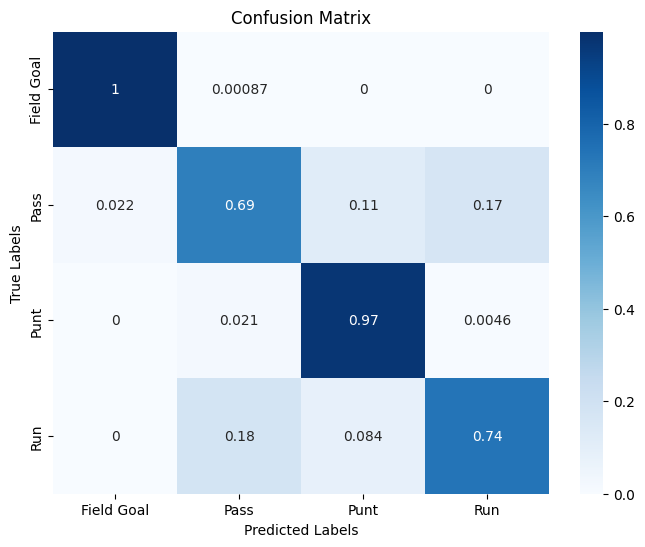

In [53]:
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

print("Classification Report:\n", report ,type(report))
class_labels = ["Field Goal","Pass", 'Punt' , "Run"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
cols = feature_selection(model, X_train, y_train)
print(cols, len(cols))


Index(['yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'ydstogo', 'ydsnet', 'fg_prob', 'td_prob', 'ep', 'drive_play_count', 'posteam_is_home', 'posteam_spread_line', 'wp_avg'], dtype='object') 12


12
Classification Report:
               precision    recall  f1-score   support

  field_goal       0.99      1.00      0.99      1148
        pass       0.78      0.69      0.73       580
        punt       0.96      0.97      0.97      2630
         run       0.69      0.74      0.71       333

    accuracy                           0.93      4691
   macro avg       0.86      0.85      0.85      4691
weighted avg       0.93      0.93      0.93      4691
 <class 'str'>


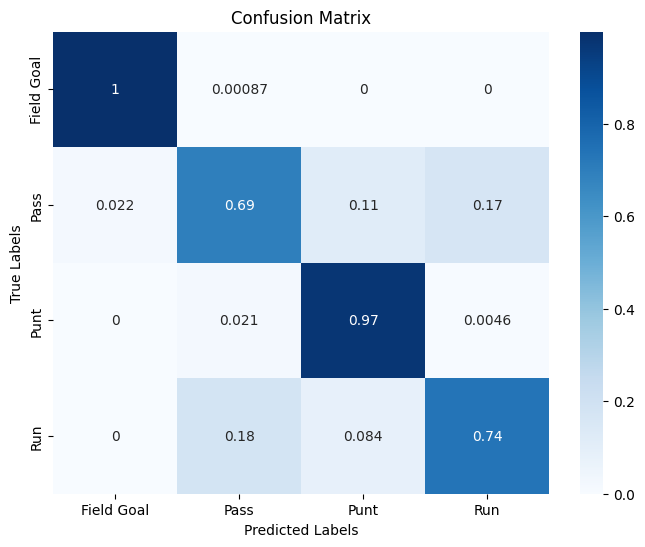

In [72]:
model = grid_search.best_estimator_
model.fit(X_train[cols] , y_train)
print(model.n_features_in_)
y_pred = model.predict(X_test[cols])
proba = model.predict_proba(X_test[cols])
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

print("Classification Report:\n", report ,type(report))
class_labels = ["Field Goal","Pass", 'Punt' , "Run"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
text = export_text(model, feature_names=cols)
print(text)
filename = "decision_tree_text.txt"

with open(filename, 'w') as file:
    # Write the text to the file
    file.write(text)


|--- fg_prob <= 0.30
|   |--- drive_play_count <= 3.50
|   |   |--- class: punt
|   |--- drive_play_count >  3.50
|   |   |--- ydstogo <= 2.50
|   |   |   |--- drive_play_count <= 6.50
|   |   |   |   |--- ydsnet <= 17.50
|   |   |   |   |   |--- class: run
|   |   |   |   |--- ydsnet >  17.50
|   |   |   |   |   |--- wp_avg <= 0.16
|   |   |   |   |   |   |--- class: pass
|   |   |   |   |   |--- wp_avg >  0.16
|   |   |   |   |   |   |--- ep <= 0.26
|   |   |   |   |   |   |   |--- half_seconds_remaining <= 8.50
|   |   |   |   |   |   |   |   |--- class: pass
|   |   |   |   |   |   |   |--- half_seconds_remaining >  8.50
|   |   |   |   |   |   |   |   |--- class: punt
|   |   |   |   |   |   |--- ep >  0.26
|   |   |   |   |   |   |   |--- class: punt
|   |   |   |--- drive_play_count >  6.50
|   |   |   |   |--- ydstogo <= 1.50
|   |   |   |   |   |--- ydsnet <= 43.50
|   |   |   |   |   |   |--- class: run
|   |   |   |   |   |--- ydsnet >  43.50
|   |   |   |   |   |   |--- cla

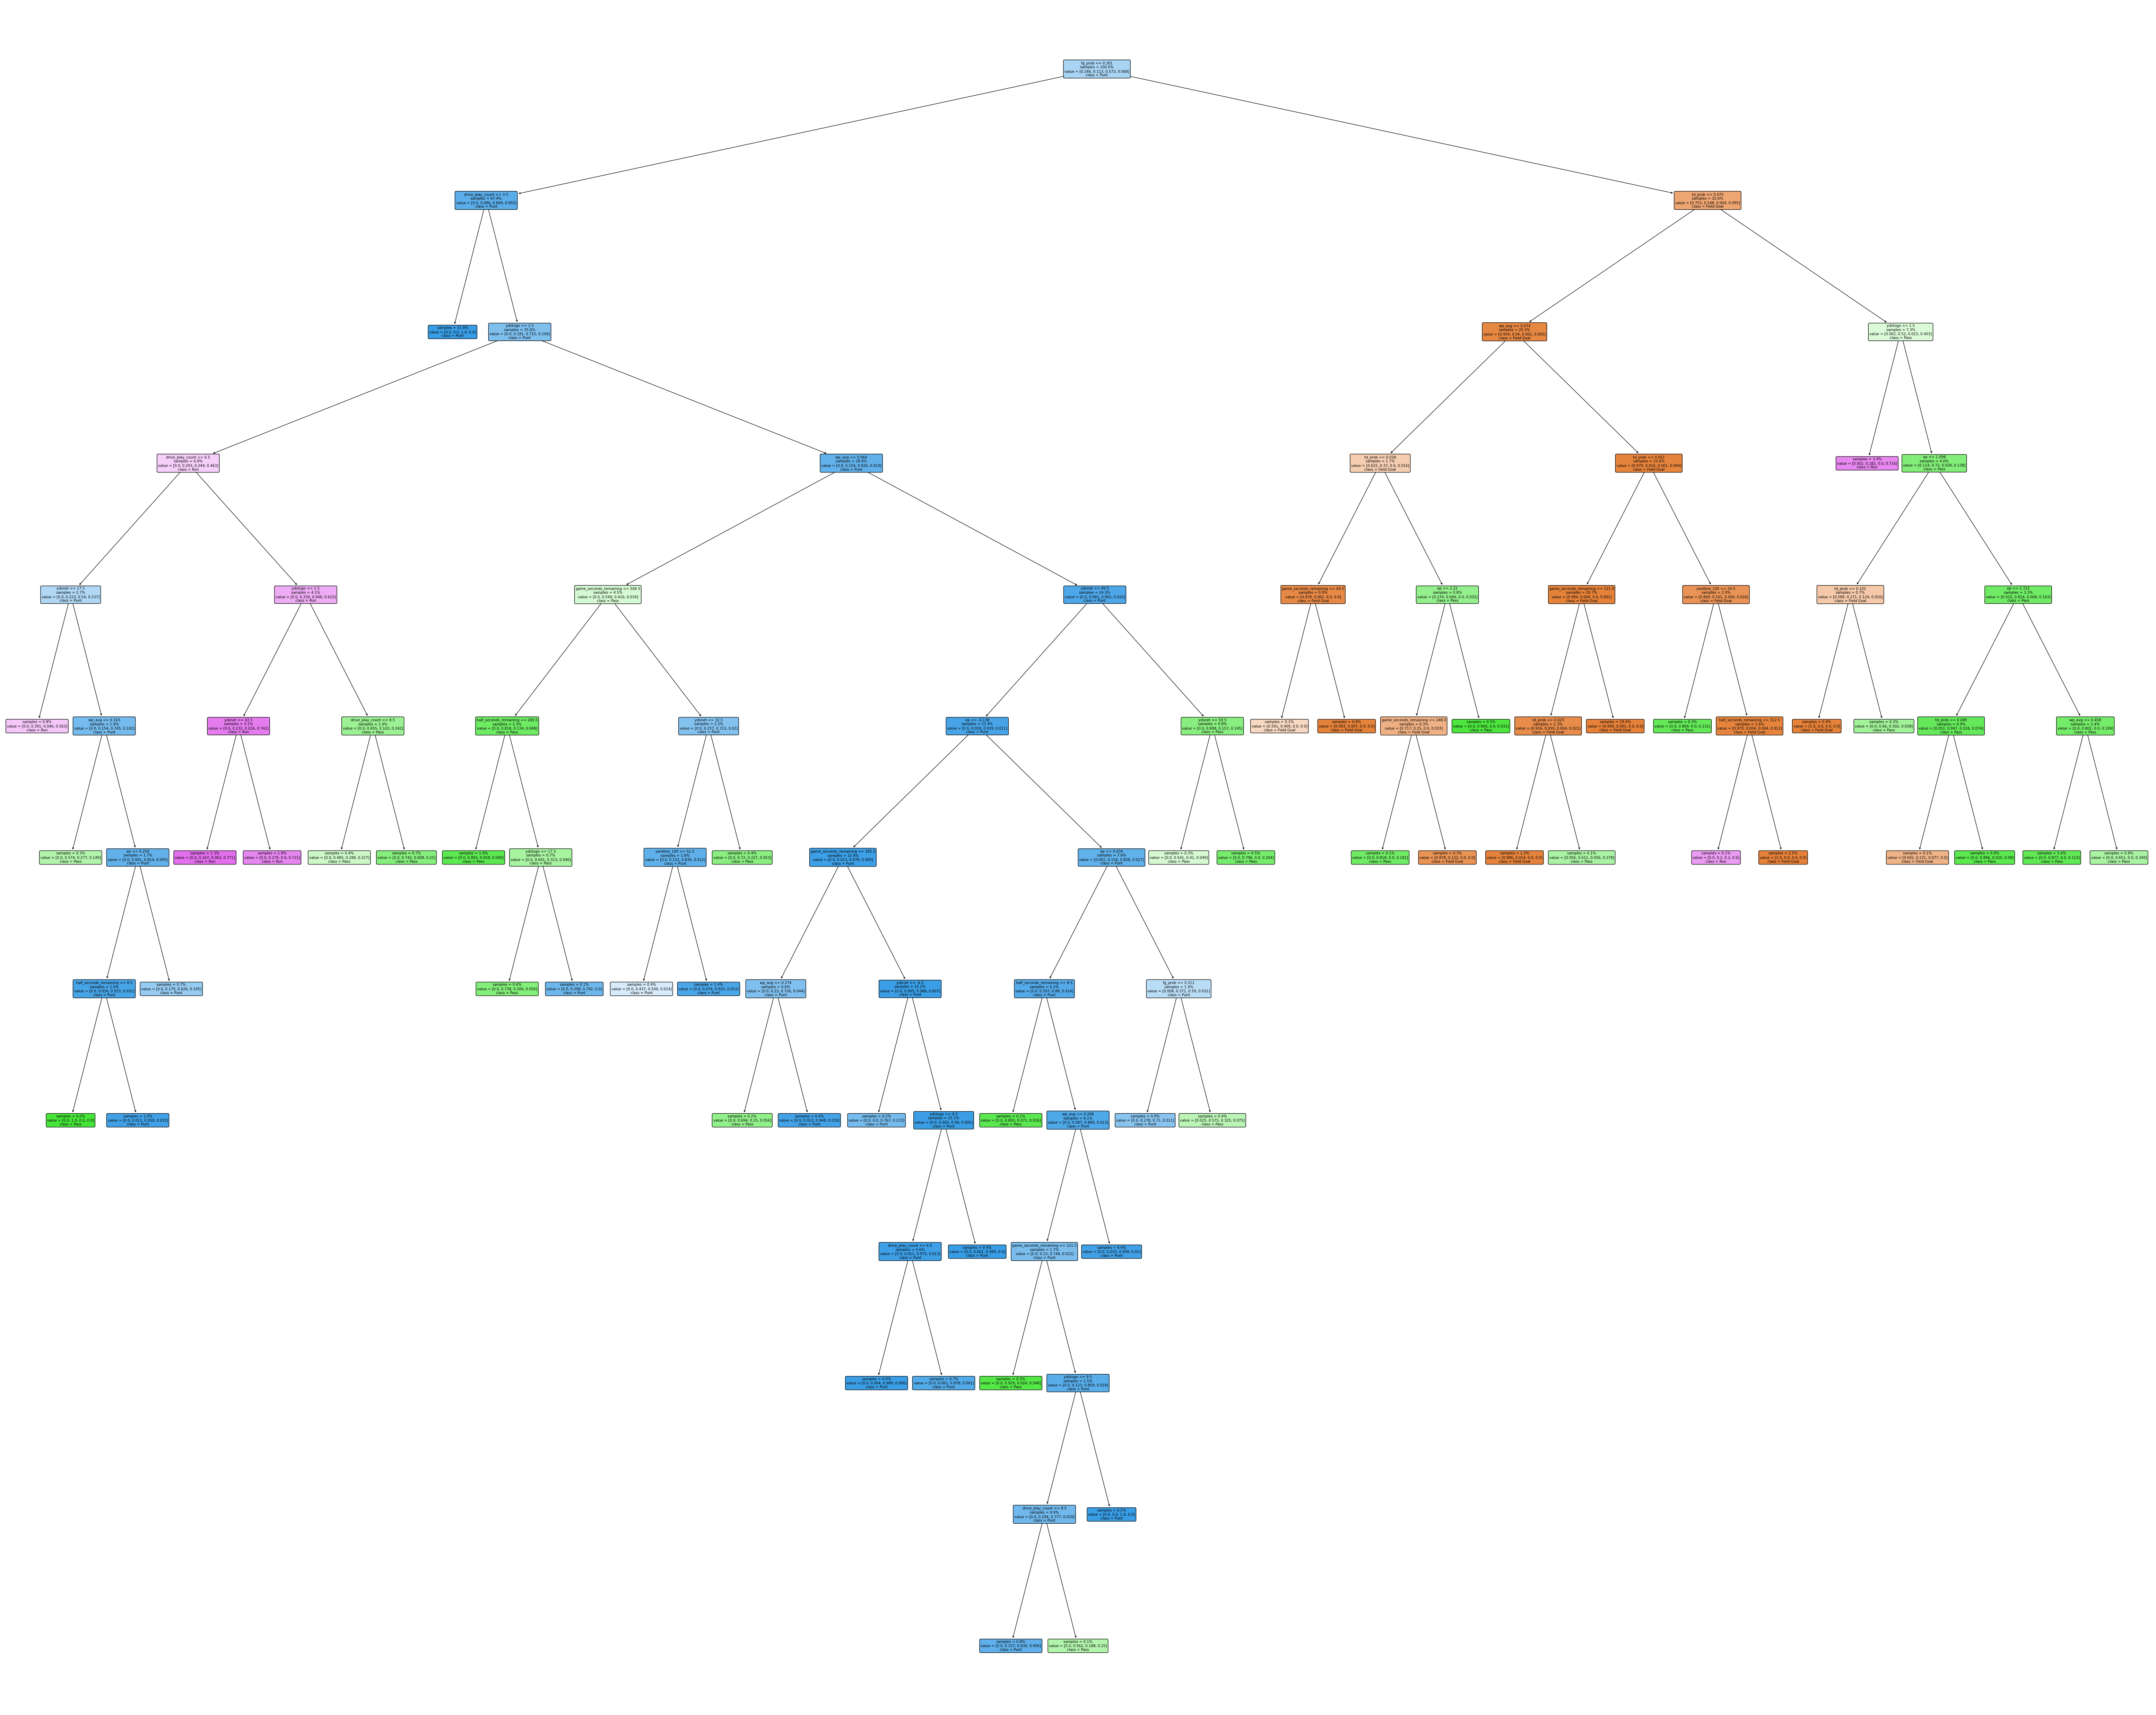

In [123]:
plt.figure(figsize=(80, 64)) 
plot_tree(model, feature_names=cols, class_names=['Field Goal', 'Pass', "Punt", "Run"],
          filled=True, impurity=False,proportion=True,rounded=True)
plt.savefig('decision_tree.png')
plt.show()


In [84]:
feature_importance_list = []
print(f"Feature Importances")
for name, imp in sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda x:x[1], reverse=True):

    print(f"{name}: {imp}")
    feature_importance_list.append((name, imp))

print("----------------------------")
    

Feature Importances
fg_prob: 0.5299544689420669
td_prob: 0.14833772680605106
drive_play_count: 0.09299583295995917
ydstogo: 0.08404927662139577
wp_avg: 0.047252258262226635
ydsnet: 0.02875797944967829
ep: 0.02796298238659306
game_seconds_remaining: 0.021487891322467586
yardline_100: 0.011129208299305053
half_seconds_remaining: 0.008072374950256598
posteam_is_home: 0.0
posteam_spread_line: 0.0
----------------------------


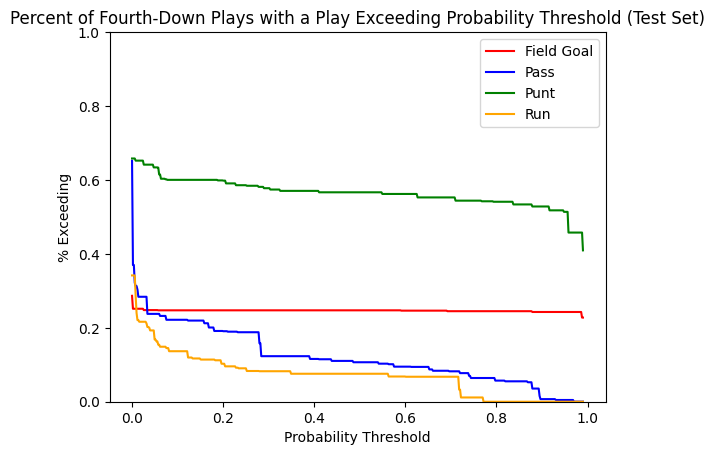

In [112]:
from collections import defaultdict
threshes = np.linspace(0.0, 0.99, 500)
percentages = defaultdict(list)


order = ['Field Goal' , 'Pass', "Punt", "Run"]

colors = ["red", "blue", "green", "orange"]

for i, pt in enumerate(order):
    pt_proba = proba[:,i]
    for thresh in threshes:
        thresh_exceeded_percent = np.mean(pt_proba > thresh)
        percentages[pt].append(thresh_exceeded_percent)

for color, pt in zip(colors, percentages):
    plt.plot(threshes, percentages[pt], color=color, label=pt)
    
plt.ylim(0, 1)
plt.xlabel("Probability Threshold")
plt.ylabel("% Exceeding")
plt.title("Percent of Fourth-Down Plays with a Play Exceeding Probability Threshold (Test Set)")
plt.legend()
plt.show()

/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_6764/3901686106.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proba_df[column], hist=False, kde_kws={'shade': True}, label=column)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_6764/3901686106.py:3: UserWarning: 

`distplot` is a deprec

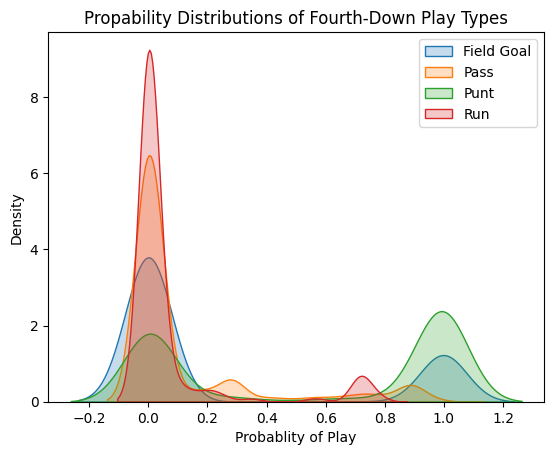

In [93]:
proba_df = pd.DataFrame(proba, columns=class_labels)
for column in proba_df.columns:
    sns.distplot(proba_df[column], hist=False, kde_kws={'shade': True}, label=column)

plt.title('Propability Distributions of Fourth-Down Play Types')
plt.xlabel('Probablity of Play')
plt.ylabel('Density')
plt.legend()
plt.show()

In [125]:
import pickle
with open('decision_tree_classifier.pkl', 'wb') as f:
    pickle.dump(model, f)